# KDEstimation (Kernel Density Estimation)
[![Build Status](https://travis-ci.com/m-wells/KDEstimation.jl.svg?branch=master)](https://travis-ci.com/m-wells/KDEstimation.jl)
[![codecov](https://codecov.io/gh/m-wells/KDEstimation.jl/branch/master/graph/badge.svg?branch=master)](https://codecov.io/gh/m-wells/KDEstimation.jl)
[![Coverage Status](https://coveralls.io/repos/github/m-wells/KDEstimation.jl/badge.svg?branch=master)](https://coveralls.io/github/m-wells/KDEstimation.jl?branch=master)

The purpose of this package is to provide a general framework for implementing Kernel Density Estimation methods.

## Univariate KDE
The density estimator
$$
\hat{f}(x)=\frac{1}{n}\sum_{i=1}^nK\left(\frac{x-x_i}{h}\right)
$$
where
* $\hat{f}(x)$ is the estimator
* $K(u)$ is the kernel function
* $h$ is the bandwidth
can be evaluated using one of three implemented methods.
* `Direct()` 
  * $O(N^2)$ where $N$ is the sample size
* `Binned()`
  * $O(M^2)$ where $M$ is the number of evaluation points
  * $M=4096$ by default
* `FFT()`
  * $O(M\log M)$ where $M$ is the number of evaluation points
  * $M=4096$ by default

## Multivariate KDE (work in progress)

## Kernels implemented
Here is a link to the [relevant wikipedia article](https://en.wikipedia.org/wiki/Kernel_(statistics)#Kernel_functions_in_common_use)

| Kernel           | $K(u)$                                                  | Support    |
|------------------|---------------------------------------------------------|------------|
|Biweight          | $\frac{15}{16}(1-u^2)^2$                                | $|u|\le 1$ |
|Cosine            | $\frac{\pi}{4}\cos(\frac{\pi}{2}u)$                     | $|u|\le 1$ |
|Epanechnikov      | $\frac{3}{4}(1-u^2)$                                    | $|u|\le 1$ |
|Logistic          | $\frac{1}{e^u+2+e^{-u}}$                                | unbounded  |
|Normal            | $\frac{1}{\sqrt{2\pi}}\exp\left(-\frac{1}{2}u^2\right)$ | unbounded  |
|SymTriangularDist | $1-|u|$                                                 | $|u|\le 1$ |
|Triweight         | $\frac{35}{32}(1-u^2)^3$                                | $|u|\le 1$ |
|Uniform           | $\frac{1}{2}$                                           | $|u|\le 1$ |

This package uses [Distributions.jl](https://github.com/JuliaStats/Distributions.jl) to suppy kernels such that $K_h\left(x-x_i\right)=\text{pdf}(D(x_i,h),x))$ where $K_h(u)=\tfrac{1}{h}K(\tfrac{u}{h}))$ and $D$) is one of the kernels listed in the table above.

__Note:__ for the Uniform distribution, [Distributions.jl](https://github.com/JuliaStats/Distributions.jl) defines `(loc,scale) = (a, b-a))` where `a` and `b` are the bounds lower and upper bounds, respectively.
This package accounts for this inconsistancy by evaluating the Uniform kernel as $\text{pdf}(\text{Uniform}(x_i-\frac{h}{2},x_i+\frac{h}{2}),x)$

## Bandwidth selection via Least Squares Cross Validation
The objective function to minimize is given by
$$
LSCV(h)=\int\hat{f}^2_h(x)dx-2\frac{1}{n}\sum_i\hat{f}_{h,-i}(X_i)
$$
where
$$
\hat{f}_{h,-i}(X_i)=\frac{1}{(n-1)h}\sum_{j\ne i}K\left(\frac{X_i-X_j}{h}\right)
$$
This has also been implemented using `Direct`, `Binned`, and `FFT` methods.

# Example usage

In [1]:
using KDEstimation, Distributions
# set a seed for reproducibility
using Random: seed!
seed!(1234)
# generate random data
x = randn(1000)
rot = rule_of_thumb2(Normal,x)
println("rule of thumb: ", rot)
lscv_res = lscv(Normal,x,FFT())

┌ Info: Precompiling KDEstimation [c13e3d18-d57b-11e9-0f19-037e2db2dfef]
└ @ Base loading.jl:1317


rule of thumb: 0.2676817928332638


LSCV{Normal,FFT(4096),1}
Results of Optimization Algorithm
 * Algorithm: Golden Section Search
 * Search Interval: [0.128205, 0.195830]
 * Minimizer: 1.616402e-01
 * Minimum: -2.789090e-01
 * Iterations: 34
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 35

# Visualization using [`Plots.jl`](https://github.com/JuliaPlots/PlotDocs.jl)

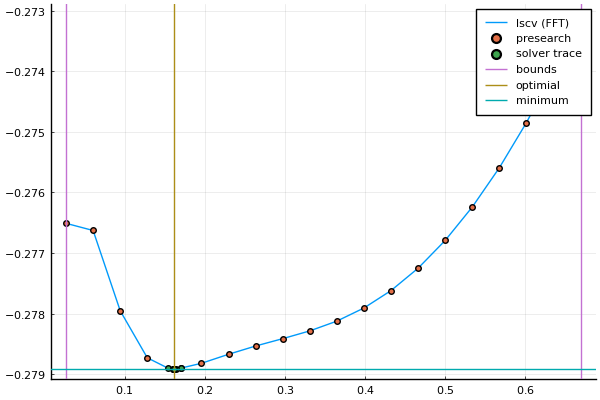

In [2]:
using Plots; pyplot()
plot(lscv_res)

In [3]:
h = minimizer(lscv_res)
fkde = kde(Normal, h, x, FFT())
frot = kde(Normal, rot, x, FFT())
# these can be called like functions
@show fkde(0.3)
@show frot(-2)
;

fkde(0.3) = 0.37927382397190534
frot(-2) = 0.05601509471009895


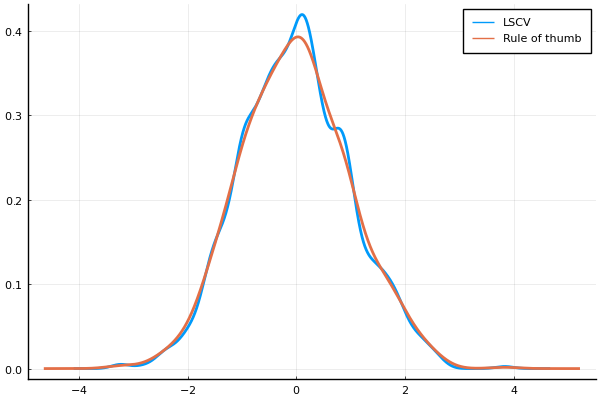

In [4]:
plot(fkde, label="LSCV", lw=2)
plot!(frot, label="Rule of thumb", lw=2)

# Further Reading
This work has been heavily influenced by Artur Gramacki's book "Nonparametric Kernel Density Estimation and Its Computational Aspects" 